In [2]:
PATH = '/home/r2sen/private/ECE 176/ECE 176 Project/'

In [3]:
!nvidia-smi -L

GPU 0: GeForce RTX 2080 Ti (UUID: GPU-e23f8e78-f8cb-a03a-4c0d-c4c8eb2fca2e)


In [19]:
#import zipfile
#with zipfile.ZipFile(PATH + 'test.zip', 'r') as zip_ref:
    #zip_ref.extractall(PATH)
#import shutil
#shutil.rmtree(PATH + 'test')

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
from torch.utils.data import Dataset
import os
import os.path as osp
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
from PIL import Image
import numpy as np
import cv2

def get_full_data_list(
    root_dir
):
    data_list = []
    for img_name in os.listdir(root_dir):
        if '.DS_Store' not in img_name:
            data_list.append(osp.join(root_dir, img_name))
    return data_list

class S_Cars(Dataset):
    def __init__(
        self,
        data_list
    ):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)
                
    def __getitem__(self, i):
        # input and target images
        in_name = self.data_list[i]
    
        # process the images
        #colorJitter = transforms.ColorJitter(
            #brightness=(1, 1.2), contrast=(0.8, 1))
        
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        transf_img = transforms.Compose([
            transforms.ToTensor(),
            normalize,
            transforms.Resize((592,400))
        ])
        in_image = Image.open(in_name).convert('RGB')
        
        in_image = transf_img(in_image)

        return in_image

TRAIN_SIZE = 1800
VAL_SIZE = 200
TEST_SIZE = 100

full_train_data_list = get_full_data_list(PATH + "cars_train")
full_test_data_list = get_full_data_list(PATH + "cars_test")
train_data_set = S_Cars(full_train_data_list[:TRAIN_SIZE])
val_data_set = S_Cars(full_train_data_list[:TRAIN_SIZE] + full_train_data_list[TRAIN_SIZE: TRAIN_SIZE +
               VAL_SIZE] + full_test_data_list[:TEST_SIZE])
test_data_set = S_Cars(full_test_data_list[:TEST_SIZE])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))



train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=8, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=16, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=8, shuffle=False
)

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

Training Set Size: 1800
Validation Set Size: 2100
Test Set Size: 100
using device: cuda


In [5]:
import random
from torch.nn import MSELoss


ratio = {0.1: 0.01, 0.2: 0.1, 0.3: 0.2, 0.4:0.3, 0.49:0.4}
def generate_random_mask(height, width, max_size):
    # Randomly choose the center of the mask

    # Randomly choose the size of the mask
    r = max_size / width
    size = random.randint(int(ratio[r]*width), int(r*width))
    
    y = random.randint(size, height - size - 1)
    x = random.randint(size, width - size - 1)
    
    # Create the mask tensor
    mask = torch.ones(3,height, width).to(device)
    # Set the pixels inside the mask to 0
    mask[:, (y - size):(y + size), (x - size):(x + size)] = 0

    return mask.unsqueeze(0)



In [6]:
class PartialConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = 0, dilation = 1, multi_channel = True, return_mask = True):

        super().__init__()
        # whether the mask is multi-channel or not
        if multi_channel:
            self.multi_channel = True
        else:
            self.multi_channel = False  

        if return_mask:
            self.return_mask = True
        else:
            self.return_mask = False

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.kernel_size = (kernel_size, kernel_size)
        self.padding = padding
        self.stride = stride
        self.dilation = dilation

        # if self.multi_channel:
        #     self.weight_maskUpdater = torch.ones(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        # else:
        #     self.weight_maskUpdater = torch.ones(1, 1, self.kernel_size[0], self.kernel_size[1])
            
        self.slide_winsize = self.in_channels * self.kernel_size[0] * self.kernel_size[1]
        
        #self.last_size = (None, None, None, None)
        self.update_mask = None
        self.mask_ratio = None

        self.input_conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                    stride, padding, dilation, groups = 1, bias = True)
        nn.init.kaiming_normal_(self.input_conv.weight)

        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                   stride, padding, dilation, groups = 1, bias = False)

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False
        

    def forward(self, input, mask_in=None):
        assert len(input.shape) == 4
        # if mask_in is not None or self.last_size != tuple(input.shape):
        #     self.last_size = tuple(input.shape)

        with torch.no_grad():
            # if self.weight_maskUpdater.type() != input.type():
            #     self.weight_maskUpdater = self.weight_maskUpdater.to(input)

            if mask_in is None:
                # if mask is not provided, create a mask
                if self.multi_channel:
                    mask = torch.ones(input.data.shape[0], input.data.shape[1], input.data.shape[2], input.data.shape[3]).to(input)
                else:
                    mask = torch.ones(1, 1, input.data.shape[2], input.data.shape[3]).to(input)
            else:
                mask = mask_in
            self.update_mask = self.mask_conv(mask)

            # for mixed precision training, change 1e-8 to 1e-6
            self.mask_ratio = self.slide_winsize/(self.update_mask + 1e-8)
            # self.mask_ratio = torch.max(self.update_mask)/(self.update_mask + 1e-8)
            self.update_mask = torch.clamp(self.update_mask, 0, 1)
            self.mask_ratio = torch.mul(self.mask_ratio, self.update_mask)


        raw_out = self.input_conv(torch.mul(input,mask))

        output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(raw_out)
        output = torch.mul(raw_out - output_bias, self.mask_ratio) + output_bias
        #output = torch.mul(output, self.update_mask)

        if self.return_mask:
            return output, self.update_mask
        else:
            return output

class InpaintNet(nn.Module):
    def __init__(self, inp_channels=3, out_channels=3):
        super().__init__()

        self.econv1 = PartialConv2d(inp_channels, 64, 5, stride=2, padding=2)
        self.bnorm1  = nn.BatchNorm2d(64)
        self.relu1   = nn.ReLU(inplace=True)

        self.econv2  = PartialConv2d(64, 64, 5, stride=1, padding=2)
        self.bnorm2  = nn.BatchNorm2d(64)
        self.relu2   = nn.ReLU(inplace=True)

        self.econv3  = PartialConv2d(64, 128, 5, stride=2, padding=2)
        self.bnorm3  = nn.BatchNorm2d(128)
        self.relu3   = nn.ReLU(inplace=True)

        self.econv4  =  PartialConv2d(128, 128, 5, stride=1, padding=2)
        self.bnorm4  =  nn.BatchNorm2d(128)
        self.relu4   = nn.ReLU(inplace=True)

        self.econv5  = PartialConv2d(128, 256, 3, stride=2, padding=1)
        self.bnorm5  = nn.BatchNorm2d(256)
        self.relu5   = nn.ReLU(inplace=True)

        self.econv6  = PartialConv2d(256, 256, 3, stride=1, padding=1)
        self.bnorm6  = nn.BatchNorm2d(256)
        self.relu6   = nn.ReLU(inplace=True)

        self.econv7  = PartialConv2d(256, 512, 3, stride=2, padding=1)
        self.bnorm7  = nn.BatchNorm2d(512)
        self.relu7   = nn.ReLU(inplace=True)

        self.econv8  = PartialConv2d(512, 512, 3, stride=1, padding=1)
        self.bnorm8  = nn.BatchNorm2d(512)
        self.relu8   = nn.ReLU(inplace=True)


        # Define the decoder network
        
            
        self.dconv1 = PartialConv2d(768, 128, 3, stride=1, padding=1)
        self.bnorm9 = nn.BatchNorm2d(128)
        self.relu9 =  nn.LeakyReLU(0.2, inplace = True)
           
        self.dconv2 = PartialConv2d(256, 64, 3, stride=1, padding=1)
        self.bnorm10 = nn.BatchNorm2d(64)
        self.relu10  = nn.LeakyReLU(0.2, inplace = True)

        self.dconv3 =  PartialConv2d(128, 3, 3, stride=1, padding=1)
        self.bnorm11 = nn.BatchNorm2d(3)
        self.relu11  = nn.LeakyReLU(0.2, inplace = True)
       
        #self.relu6 =   nn.LeakyReLU(0.2, inplace = True)

        self.dconv4 =  PartialConv2d(6, 3, 3, stride=1, padding=1)
        #self.relu6 =   nn.LeakyReLU(0.2, inplace = True)

        self.up = nn.UpsamplingNearest2d(scale_factor = 2)

    def forward(self, x, mask):
        # Apply the mask to the input image
        #x = x * mask

        # Encode the masked image
        enc_outputs = []
        mask_out = []

        enc_outputs.append(x)
        mask_out.append(mask)

        enc_1,mask = self.econv1(x, mask)
        enc_1 = self.relu1(self.bnorm1(enc_1))

        enc_2,mask = self.econv2(enc_1, mask)
        enc_2 = self.relu2(self.bnorm2(enc_2))
        enc_outputs.append(enc_2)
        mask_out.append(mask)

        enc_3,mask = self.econv3(enc_2, mask)
        enc_3 = self.relu3(self.bnorm3(enc_3))

        enc_4,mask = self.econv4(enc_3, mask)
        enc_4 = self.relu4(self.bnorm4(enc_4))
        enc_outputs.append(enc_4)
        mask_out.append(mask)

        enc_5,mask = self.econv5(enc_4, mask)
        enc_5 = self.relu5(self.bnorm5(enc_5))

        enc_6,mask = self.econv6(enc_5, mask)
        enc_6 = self.relu6(self.bnorm6(enc_6))
        enc_outputs.append(enc_6)
        mask_out.append(mask)

        enc_7,mask = self.econv7(enc_6, mask)
        enc_7 = self.relu7(self.bnorm7(enc_7))

        enc_8,mask = self.econv8(enc_7, mask)
        enc_8 = self.relu8(self.bnorm8(enc_8))

        # Reverse the encoder outputs and mask
        #mask = mask[::-1]

        
        # Decode the masked and encoded image
        enc_8 = self.up(enc_8)
        mask = self.up(mask)
        concat_1 = torch.cat([enc_8, enc_outputs[3]], dim=1)
        mask_concat1 = torch.cat([mask, mask_out[3]], dim=1)
        dec_1,mask = self.dconv1(concat_1, mask_concat1)
        dec_1 = self.relu9(self.bnorm9(dec_1))

        dec_2 = self.up(dec_1)
        mask = self.up(mask)
        concat_2 = torch.cat([dec_2, enc_outputs[2]], dim=1)
        mask_concat2 = torch.cat([mask, mask_out[2]], dim=1)
        dec_2, mask = self.dconv2(concat_2, mask_concat2)
        dec_2 = self.relu10(self.bnorm10(dec_2))

        dec_3 = self.up(dec_2)
        mask = self.up(mask)
        concat_3 = torch.cat([dec_3, enc_outputs[1]], dim=1)
        mask_concat3 = torch.cat([mask, mask_out[1]], dim=1)
        dec_3, mask = self.dconv3(concat_3, mask_concat3)
        dec_3 = self.relu11(self.bnorm11(dec_3))

        dec_4 = self.up(dec_3)
        mask = self.up(mask)
        concat_4 = torch.cat([dec_4, enc_outputs[0]], dim=1)
        mask_concat4 = torch.cat([mask, mask_out[0]], dim=1)
        dec_4, mask = self.dconv4(concat_4, mask_concat4)

        return dec_4


In [7]:
###############################################################################
# BSD 3-Clause License
#
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# Author & Contact: Guilin Liu (guilinl@nvidia.com)
###############################################################################
"""VGG Losses"""

import torch
import torch.nn as nn

from torch.autograd import Variable
from torchvision import models


def gram_matrix(input_tensor):
    """
    Compute Gram matrix

    :param input_tensor: input tensor with shape
     (batch_size, nbr_channels, height, width)
    :return: Gram matrix of y
    """
    (b, ch, h, w) = input_tensor.size()
    features = input_tensor.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    
    # more efficient and formal way to avoid underflow for mixed precision training
    input = torch.zeros(b, ch, ch).type(features.type())
    gram = torch.baddbmm(input, features, features_t, beta=0, alpha=1./(ch * h * w), out=None)
    
    # naive way to avoid underflow for mixed precision training
    # features = features / (ch * h)
    # gram = features.bmm(features_t) / w

    # for fp32 training, it is also safe to use the following:
    # gram = features.bmm(features_t) / (ch * h * w)

    return gram

class PerceptualLoss(nn.Module):
    """
    Perceptual Loss Module
    """
    def __init__(self):
        """Init"""
        super().__init__()
        self.l1_loss = torch.nn.L1Loss()
        self.mse_loss = torch.nn.MSELoss()

    @staticmethod
    def normalize_batch(batch, div_factor=255.):
        """
        Normalize batch

        :param batch: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :param div_factor: normalizing factor before data whitening
        :return: normalized data, tensor with shape
         (batch_size, nbr_channels, height, width)
        """
        # normalize using imagenet mean and std
        mean = batch.data.new(batch.data.size())
        std = batch.data.new(batch.data.size())
        mean[:, 0, :, :] = 0.485
        mean[:, 1, :, :] = 0.456
        mean[:, 2, :, :] = 0.406
        std[:, 0, :, :] = 0.229
        std[:, 1, :, :] = 0.224
        std[:, 2, :, :] = 0.225
        batch = torch.div(batch, div_factor)

        batch -= Variable(mean)
        batch = torch.div(batch, Variable(std))
        return batch

    def forward(self, x, y):
        """
        Forward

        :param x: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :param y: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :return: l1 loss between the normalized data
        """
        x = self.normalize_batch(x)
        y = self.normalize_batch(y)
        return self.l1_loss(x, y)

def make_vgg16_layers(style_avg_pool = False):
    """
    make_vgg16_layers

    Return a custom vgg16 feature module with avg pooling
    """
    vgg16_cfg = [
        64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M',
        512, 512, 512, 'M', 512, 512, 512, 'M'
    ]

    layers = []
    in_channels = 3
    for v in vgg16_cfg:
        if v == 'M':
            if style_avg_pool:
                layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGG16Partial(nn.Module):
    """
    VGG16 partial model
    """
    def __init__(self, vgg_path='~/.torch/vgg16-397923af.pth', layer_num=3):
        """
        Init

        :param layer_num: number of layers
        """
        super().__init__()
        vgg_model = models.vgg16(pretrained=True)
        #vgg_model.features = make_vgg16_layers()
        #vgg_model.load_state_dict(torch.load(vgg_path, map_location='cpu'))
        vgg_pretrained_features = vgg_model.features

        assert layer_num > 0
        assert isinstance(layer_num, int)
        self.layer_num = layer_num

        self.slice1 = torch.nn.Sequential()
        for x in range(5):  # 4
            self.slice1.add_module(str(x), vgg_pretrained_features[x])

        if self.layer_num > 1:
            self.slice2 = torch.nn.Sequential()
            for x in range(5, 10):  # (4, 9)
                self.slice2.add_module(str(x), vgg_pretrained_features[x])

        if self.layer_num > 2:
            self.slice3 = torch.nn.Sequential()
            for x in range(10, 17):  # (9, 16)
                self.slice3.add_module(str(x), vgg_pretrained_features[x])

        if self.layer_num > 3:
            self.slice4 = torch.nn.Sequential()
            for x in range(17, 24):  # (16, 23)
                self.slice4.add_module(str(x), vgg_pretrained_features[x])

        for param in self.parameters():
            param.requires_grad = False

    @staticmethod
    def normalize_batch(batch, div_factor=1.0):
        """
        Normalize batch

        :param batch: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :param div_factor: normalizing factor before data whitening
        :return: normalized data, tensor with shape
         (batch_size, nbr_channels, height, width)
        """
        # normalize using imagenet mean and std
        mean = batch.data.new(batch.data.size())
        std = batch.data.new(batch.data.size())
        mean[:, 0, :, :] = 0.485
        mean[:, 1, :, :] = 0.456
        mean[:, 2, :, :] = 0.406
        std[:, 0, :, :] = 0.229
        std[:, 1, :, :] = 0.224
        std[:, 2, :, :] = 0.225
        batch = torch.div(batch, div_factor)

        batch -= Variable(mean)
        batch = torch.div(batch, Variable(std))
        return batch

    def forward(self, x):
        """
        Forward, get features used for perceptual loss

        :param x: input tensor with shape
         (batch_size, nbr_channels, height, width)
        :return: list of self.layer_num feature maps used to compute the
         perceptual loss
        """
        h = self.slice1(x)
        h1 = h

        output = []

        if self.layer_num == 1:
            output = [h1]
        elif self.layer_num == 2:
            h = self.slice2(h)
            h2 = h
            output = [h1, h2]
        elif self.layer_num == 3:
            h = self.slice2(h)
            h2 = h
            h = self.slice3(h)
            h3 = h
            output = [h1, h2, h3]
        elif self.layer_num >= 4:
            h = self.slice2(h)
            h2 = h
            h = self.slice3(h)
            h3 = h
            h = self.slice4(h)
            h4 = h
            output = [h1, h2, h3, h4]
        return output


# perceptual loss and (spatial) style loss
class VGG16PartialLoss(PerceptualLoss):
    """
    VGG16 perceptual loss
    """
    def __init__(self, l1_alpha=5.0, perceptual_alpha=0.05, style_alpha=120,
                 smooth_alpha=0, feat_num=3, vgg_path='~/.torch/vgg16-397923af.pth'):
        """
        Init

        :param l1_alpha: weight of the l1 loss
        :param perceptual_alpha: weight of the perceptual loss
        :param style_alpha: weight of the style loss
        :param smooth_alpha: weight of the regularizer
        :param feat_num: number of feature maps
        """
        super().__init__()

        self.vgg16partial = VGG16Partial(vgg_path=vgg_path).eval()

        self.loss_fn = torch.nn.L1Loss(size_average=True)

        self.l1_weight = l1_alpha
        self.vgg_weight = perceptual_alpha
        self.style_weight = style_alpha
        self.regularize_weight = smooth_alpha

        self.dividor = 1
        self.feat_num = feat_num

    def forward(self, output0, target0):
        """
        Forward

        assuming both output0 and target0 are in the range of [0, 1]

        :param output0: output of a model, tensor with shape
         (batch_size, nbr_channels, height, width)
        :param target0: target, tensor with shape
         (batch_size, nbr_channels, height, width)
        :return: total perceptual loss
        """
        y = self.normalize_batch(target0, self.dividor)
        x = self.normalize_batch(output0, self.dividor)

        # L1 loss
        l1_loss = self.l1_weight * (torch.abs(x - y).mean())
        vgg_loss = 0
        style_loss = 0
        smooth_loss = 0

        # VGG
        if self.vgg_weight != 0 or self.style_weight != 0:

            yc = Variable(y.data)

            with torch.no_grad():
                groundtruth = self.vgg16partial(yc)
            generated = self.vgg16partial(x)
            
            # vgg loss: VGG content loss
            if self.vgg_weight > 0:
                # for m in range(0, len(generated)):
                for m in range(len(generated) - self.feat_num, len(generated)):

                    gt_data = Variable(groundtruth[m].data, requires_grad=False)
                    vgg_loss += (
                        self.vgg_weight * self.loss_fn(generated[m], gt_data)
                    )

            
            # style loss: Gram matrix loss
            if self.style_weight > 0:
                # for m in range(0, len(generated)):
                for m in range(len(generated) - self.feat_num, len(generated)):

                    gt_style = gram_matrix(
                        Variable(groundtruth[m].data, requires_grad=False))
                    gen_style = gram_matrix(generated[m])
                    style_loss += (
                        self.style_weight * self.loss_fn(gen_style, gt_style)
                    )

        # smooth term
        if self.regularize_weight != 0:
            smooth_loss += self.regularize_weight * (
                torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:]).mean() +
                torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]).mean()
            )

        tot = l1_loss + vgg_loss + style_loss + smooth_loss
        return tot, vgg_loss, style_loss


In [8]:
pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Validation Loss functions

from torchmetrics import StructuralSimilarityIndexMeasure


def ssim_loss(img1, img2, window_size=11, size_average=True, full=False):

    # Set up constants
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    # Calculate means
    mu1 = F.avg_pool2d(img1, window_size, stride=1, padding=0)
    mu2 = F.avg_pool2d(img2, window_size, stride=1, padding=0)

    # Calculate variances
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 ** 2, window_size, stride=1, padding=0) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 ** 2, window_size, stride=1, padding=0) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, window_size, stride=1, padding=0) - mu1_mu2

    # Calculate SSIM
    numerator = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)

    ssim_map = numerator / denominator

    if full:
        return ssim_map.mean()

    if size_average:
        return 1 - ssim_map.mean()
    else:
        return 1 - ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2):
    ssim = StructuralSimilarityIndexMeasure(data_range=255.0).to(device)
    result = ssim(img1, img2)
    return result

def l1_pixel_loss(img1, img2):
    # Calculate L1 pixel loss
    loss = torch.mean(torch.abs(img1 - img2))

    return loss

def psnr(img1, img2):
    # Calculate MSE
    mse = torch.mean((img1 - img2) ** 2)

    # Calculate PSNR
    max_val = 255.0
    psnr = 20 * torch.log10(max_val / torch.sqrt(mse) + 1e-7)

    return psnr

In [10]:
def Evaluate(
    val_loader,
    model,
    ratio
):
    
    avg_loss, ssimloss, l1pixelloss, snr = 0, 0, 0, 0
    batch_idx = 0

    model.eval()
    for batch_idx, data in enumerate(val_loader):
        data = data.to(device)
        with torch.no_grad():
            _,_,ht,w = data.size()
            mask = generate_random_mask(ht,w, ratio*w)
            score = model(data, mask)

            avg_loss += nn.MSELoss()(score, data)  
            ssimloss += ssim(score, data)
            l1pixelloss += l1_pixel_loss(score, data)
            snr += psnr(score, data)
    
    ssimloss /= len(val_loader)
    l1pixelloss /= len(val_loader)
    snr /= len(val_loader)
    print('SSIM, L1 pixel loss, SNR: {}, {}, {}'.format(ssimloss, l1pixelloss, snr))
    torch.cuda.empty_cache()
    return avg_loss/len(val_loader)

def Train(
    model,
    optim,
    scheduler,
    epochs,
    train_loader,
    val_loader,
    test_loader,
    display_interval = 100
):

    # style_loss_func = StyleLoss()
    # style_loss_func.to(device)
    per_pixel_loss = nn.MSELoss()
    vgg_loss = VGG16PartialLoss(smooth_alpha = 0.1, vgg_path=PATH + 'models/vgg11-bbd30ac9.pth')
    vgg_loss = vgg_loss.to(device)
    # #Percept_loss_func =  PerceptualLoss()
    # #Percept_loss_func.to(device)

    

    for i in range(epochs):
        print("Epochs: {}".format(i))
        total_loss = 0
        model.train()
        
        for batch_idx, data in enumerate(train_loader):
            data = data.to("cuda:0")
            optim.zero_grad()

            _,_,ht,w = data.size()
            mask = generate_random_mask(ht,w, ht//4)
            score = model(data, mask)
            loss = per_pixel_loss(torch.mul(data, mask), torch.mul(score,mask)) + 6 * per_pixel_loss(torch.mul(data, 1 -mask), torch.mul(score,1 - mask))
            tot, ploss, sloss = vgg_loss(score, data)
            loss += ploss + sloss
            loss.backward()
            optim.step()
            total_loss += loss
            
        
        total_loss /= len(train_loader)
        model.eval()
        avg_val_loss = Evaluate(
            val_loader,
            model
        )
        scheduler.step(total_loss)
        print("Avg Train Loss: {:.4}, Avg Val Loss: {:.4}".format(
            total_loss, avg_val_loss
        ))
        torch.cuda.empty_cache()
    return model


from torch.optim.lr_scheduler import ReduceLROnPlateau

def Trainer(model, 
            train_loader,
            val_loader,
            test_loader,
            num_epochs=25, 
            ):
    # define optimizer
    lr = 1e-1
    weight_decay = 1e-5
    optim = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay,
    )
    
    # define learning rate schedule
    scheduler = ReduceLROnPlateau(
        optim, 'min', patience=3,
        min_lr=1e-10, verbose=True
    )
    
    # define loss function

    best_model = Train(
        model,
        optim,
        scheduler,
        num_epochs,
        train_loader,
        val_loader,
        test_loader
    )

    return best_model

In [27]:
model = InpaintNet()
model.to(device)
model.load_state_dict(torch.load(PATH + 'pconv_vgg_sc_resize_20.pth', map_location='cpu'))
#best_model = Trainer(
#    model,
#    train_loader,
#    val_loader,
#    test_loader,
#    num_epochs=20
#)

<All keys matched successfully>

In [11]:
#for r in ratio.keys():
    #print("For hole to image ratio in range: {}, {}".format(ratio[r], r))
    #avg_val_loss =  Evaluate(
    #            val_loader,
    #            model,
    #            r
    #)

For hole to image ratio in range: 0.01, 0.1
SSIM, L1 pixel loss, SNR: 0.999244749546051, 0.04923636466264725, 67.66897583007812
For hole to image ratio in range: 0.1, 0.2
SSIM, L1 pixel loss, SNR: 0.9948796033859253, 0.0859261006116867, 61.25657272338867
For hole to image ratio in range: 0.2, 0.3
SSIM, L1 pixel loss, SNR: 0.9832366704940796, 0.16787107288837433, 56.17616271972656
For hole to image ratio in range: 0.3, 0.4
SSIM, L1 pixel loss, SNR: 0.9622078537940979, 0.31022924184799194, 52.632591247558594
For hole to image ratio in range: 0.4, 0.49
SSIM, L1 pixel loss, SNR: 0.934116005897522, 0.4921262860298157, 50.178062438964844


(592, 400, 3)


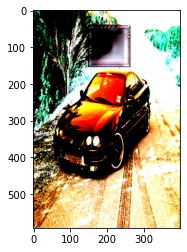

In [28]:
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
#torch.save(best_model.state_dict(), PATH + 'pconv_vgg_sc_resize_20.pth')
data = train_loader.dataset[44].unsqueeze(0).to(device)

_,_,ht,w = data.size()

mask = generate_random_mask(ht,w,0.2*w).to(device)
best_model = model        
score = best_model(data, mask)
score = torch.clamp(score, 0.0, 1.0) * 255

# Convert the output tensor to a numpy array

#from google.colab.patches import cv2_imshow

data = torch.clamp(data, 0.0, 1.0) * 255

data = data.squeeze().detach().cpu().numpy().transpose((1,2,0))


# convert the tensor to a numpy array
img_array = score.squeeze().detach().cpu().numpy()

# reshape the array into a 3D image with shape (height, width, channels)
img_array = np.transpose(img_array, (1, 2, 0))

# convert the array back to an image in the original format (e.g. RGB or grayscale)
img = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR).astype(int)
data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)


mask = mask.squeeze().detach().cpu().numpy().transpose((1,2,0)) * 255

print(img.shape)
plt.imshow(img)
plt.show()